In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns

# Optimisation

In [2]:
ACTORNAME = "Gorssel"

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

In [4]:
cases = {0: "best", 1: "low", 2: "middle", 3: "high", 4: "worst deaths", 5: "absolute worst"}

## Reading

In [5]:
read_results = []

for _,case in cases.items():
    temp = pd.read_csv("data/optimisation/" + ACTORNAME + "/results_" + case +".csv")
    temp_ = pd.read_csv("data/optimisation/" + ACTORNAME + "/convergence_" + case +".csv")
    read_results.append([temp, temp_])

In [6]:
opt_df = pd.DataFrame()
for i, (result, convergence) in enumerate(read_results):
    opt_df = pd.concat([opt_df, result], axis=0)

Below we plot per scenario 

In [7]:
opt_df.loc[opt_df["EWS_DaysToThreat"] > 0]

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
0,0,0,0,1,1,1,1,0,0,0,5,0,5,0.000000e+00,0.000000,0.000000e+00
0,0,0,0,1,1,1,2,1,0,0,0,3,5,0.000000e+00,0.000000,6.320800e+06
1,0,0,0,1,1,1,1,0,0,0,2,4,2,3.508236e+06,0.000612,1.256299e+02
0,0,0,0,1,1,1,2,3,0,0,6,1,4,0.000000e+00,0.000000,8.453408e+06
1,0,0,0,1,1,1,1,1,0,0,6,6,4,4.127710e+06,0.000892,6.320976e+06
2,0,0,0,1,1,1,2,0,0,0,2,7,4,7.042495e+06,0.000613,5.088447e+02
0,0,0,0,1,0,1,1,8,0,0,10,4,1,0.000000e+00,0.000000,1.610892e+07
1,0,0,0,1,1,1,3,0,0,0,1,1,7,1.077430e+08,0.005126,8.387882e+03
2,0,0,0,1,1,1,1,6,0,0,3,1,2,4.057787e+06,0.000762,1.258659e+07
3,0,0,0,1,1,1,3,1,0,0,9,6,4,9.451100e+07,0.004658,6.328075e+06


In [8]:
policyoutcomes = opt_df.iloc[:, -3:]

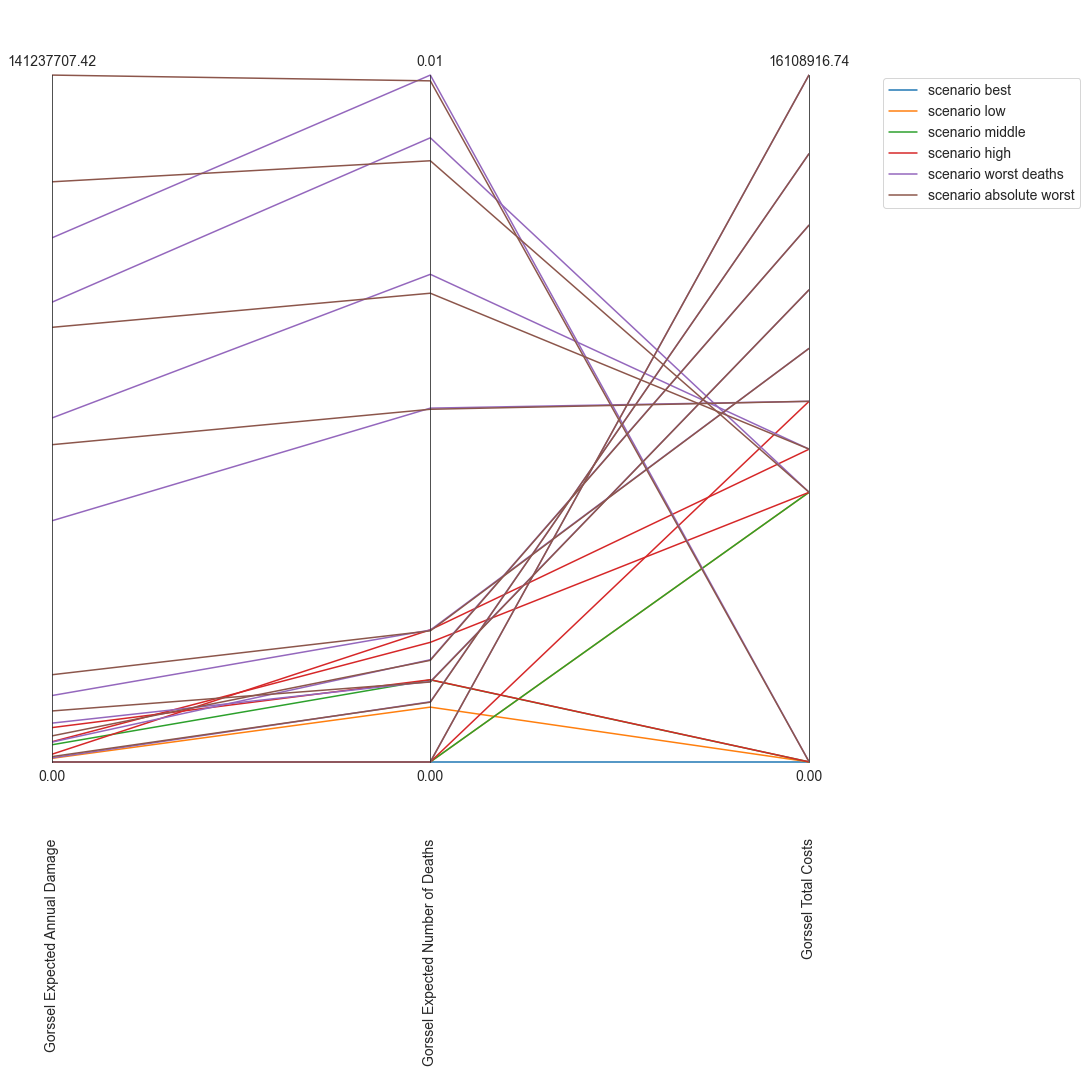

In [21]:
colors = iter(sns.color_palette())
limits = parcoords.get_limits(policyoutcomes)

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(read_results):
    color = next(colors)
    data = result.iloc[:,  -3:]
    paraxes.plot(data, label=f'scenario {cases[i]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)

plt.show()


# Reevaluate under deep uncertainty

## Reading

In [10]:
n_scenarios = 1000

In [11]:
du_experiments, du_outcomes = load_results("data/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

## Regret
Comparing alternatives
"With a regret view, a decision maker wants to minimize the regret of choosing incorrectly, where regret is the loss in performance. This regret could be the cost of assuming the wrong future scenario or the cost of choosing the wrong alternative. In the first case, maximum regret of an alternative is the difference between its performances in the best estimate future scenario and in the scenario where it shows the worst performance, for example, as applied by Kasprzyk et al. (2013). In the second case, the regret of an alternative in a certain future scenario is the difference between its performance and the best-performing alternative, as proposed by Savage (1951). Maximum regret of an alternative is its highest regret achieved over all future scenarios. In both regret cases, the alternative with the smallest maximum regret is the most robust."

https://link.springer.com/article/10.1007/s13595-017-0641-2

In [12]:
outcomekeys = list(du_outcomes.keys())
outcomekeys

['Difference in Expected Annual Damage Gorssel-Deventer',
 'Difference in Expected Number of Deaths Gorssel-Deventer',
 'Gorssel Expected Annual Damage',
 'Gorssel Expected Number of Deaths',
 'Gorssel Total Costs']

In [13]:
DAMAGE = outcomekeys[2]
DEATHS = outcomekeys[3]
COSTS = outcomekeys[4]

### Kwakkels stuff - still have to test and adept but laptop sloooow

In [14]:
overall_scores = {}
regret = []
for scenario in du_experiments.scenario.unique():
    logical = du_experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in du_outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = du_experiments[du_experiments.scenario==scenario]
    
    best = temp_results.max()
    best['Damage'] = temp_results[DAMAGE].min()
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

In [15]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

In [16]:
subregret = maxregret.iloc[:, 1:].copy()

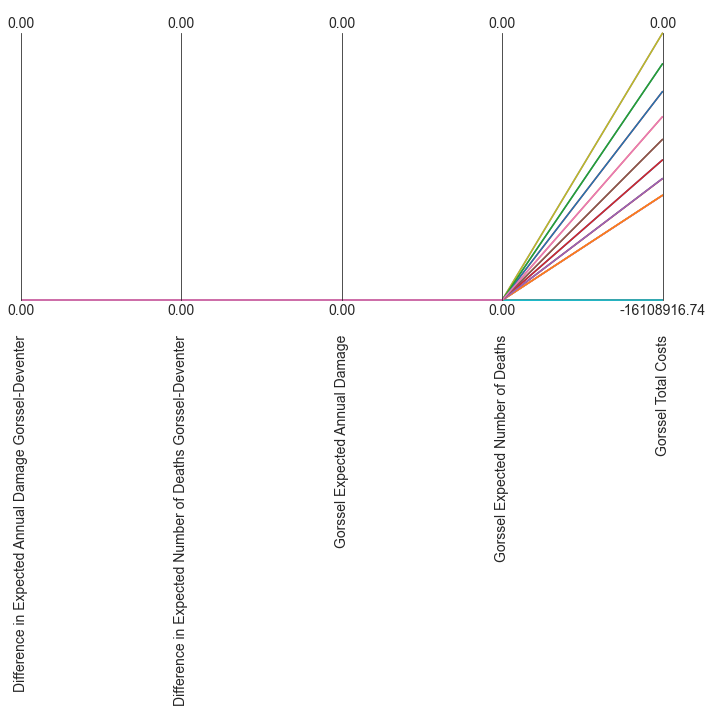

In [17]:
limits = parcoords.get_limits(subregret)
paraxes = parcoords.ParallelAxes(subregret)
paraxes.plot(maxregret)
plt.rcParams["figure.figsize"] = (12,15)
plt.show()

In [22]:
temp_results

,Difference in Expected Annual Damage Gorssel-Deventer,Difference in Expected Number of Deaths Gorssel-Deventer,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
0,-1016.346608,-2.520879e-07,629588.234503,0.000106,1.702388e+01
1,-2545.671943,-1.748385e-06,0.000000,0.000000,6.320800e+06
2,-6.250938,-2.911435e-09,629588.234503,0.000293,0.000000e+00
3,-4998.693633,-4.976397e-07,0.000000,0.000000,6.320800e+06
4,-2101.344150,-5.106266e-07,629588.234503,0.000106,1.702388e+01
5,-107.488806,-1.127812e-08,0.000000,0.000000,8.453408e+06
6,0.000000,0.000000e+00,0.000000,0.000000,6.320800e+06
7,-1869.570786,-1.885220e-07,629588.234503,0.000044,2.826230e+01
8,-668.093812,-4.617594e-07,0.000000,0.000000,7.332080e+06
9,0.000000,0.000000e+00,0.000000,0.000000,1.610892e+07


## Satisficing
Performance threshold
"seeks a decision alternative that meets his or her performance requirements over the range of plausible future scenarios. "

In [25]:
tresholds = {'tresh_damage': 629588 , 'tresh_death': 0.0001,
              'tresh_costs': 100000}
satisfycing_df = opt_df.copy()
satisfycing_df.drop_duplicates(inplace=True)
satisfycing_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
0,0,0,0,1,1,1,1,0,0,0,5,0,5,0.000000e+00,0.000000,0.000000e+00
0,0,0,0,0,1,1,0,1,0,0,3,0,4,0.000000e+00,0.000000,6.320800e+06
1,0,0,0,1,1,1,0,0,0,0,6,7,7,7.196999e+05,0.000409,0.000000e+00
0,0,0,0,1,1,1,2,1,0,0,0,3,5,0.000000e+00,0.000000,6.320800e+06
1,0,0,0,1,1,1,1,0,0,0,2,4,2,3.508236e+06,0.000612,1.256299e+02
0,0,0,0,1,1,1,2,3,0,0,6,1,4,0.000000e+00,0.000000,8.453408e+06
1,0,0,0,1,1,1,1,1,0,0,6,6,4,4.127710e+06,0.000892,6.320976e+06
2,0,0,0,1,1,1,2,0,0,0,2,7,4,7.042495e+06,0.000613,5.088447e+02
3,0,0,0,1,1,1,0,2,0,0,5,1,9,1.555551e+06,0.000986,7.332080e+06
0,0,0,0,1,0,1,1,8,0,0,10,4,1,0.000000e+00,0.000000,1.610892e+07


In [23]:
belowtresh_df = satisfycing_df.loc[(satisfycing_df['Gorssel Expected Annual Damage'] < tresholds['tresh_damage']) & \
                    (satisfycing_df['Gorssel Expected Number of Deaths'] < tresholds['tresh_death']) & \
                    (satisfycing_df['Gorssel Expected Number of Deaths'] < tresholds['tresh_costs']),:].copy()
belowtresh_df.sort_index(inplace=True, ascending = False)
belowtresh_df

,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths,Gorssel Total Costs
8,0,0,0,1,1,1,3,1,0,0,2,4,7,1.192887e+08,0.004487,6.327747e+06
8,0,0,0,1,1,1,2,5,0,0,3,4,1,7.963552e+06,0.000600,1.106922e+07
7,0,0,0,1,1,1,3,2,0,0,6,0,3,8.935890e+07,0.003498,7.337211e+06
7,0,0,0,1,1,1,2,4,0,0,3,6,5,1.363324e+07,0.000984,9.695982e+06
6,0,0,0,1,1,1,3,3,0,0,3,2,3,6.522382e+07,0.002632,8.457109e+06
6,0,0,0,1,1,1,3,2,0,0,6,6,6,7.070223e+07,0.003639,7.337440e+06
5,0,0,0,1,1,1,3,3,0,0,5,1,5,4.956868e+07,0.002640,8.457116e+06
5,0,0,0,1,1,1,2,4,0,0,3,6,3,1.791298e+07,0.000978,9.695980e+06
4,0,0,0,1,1,1,3,8,0,0,2,5,3,0.000000e+00,0.000000,1.610892e+07
4,0,0,0,1,1,1,0,7,0,0,10,4,1,8.184661e+05,0.000448,1.426165e+07


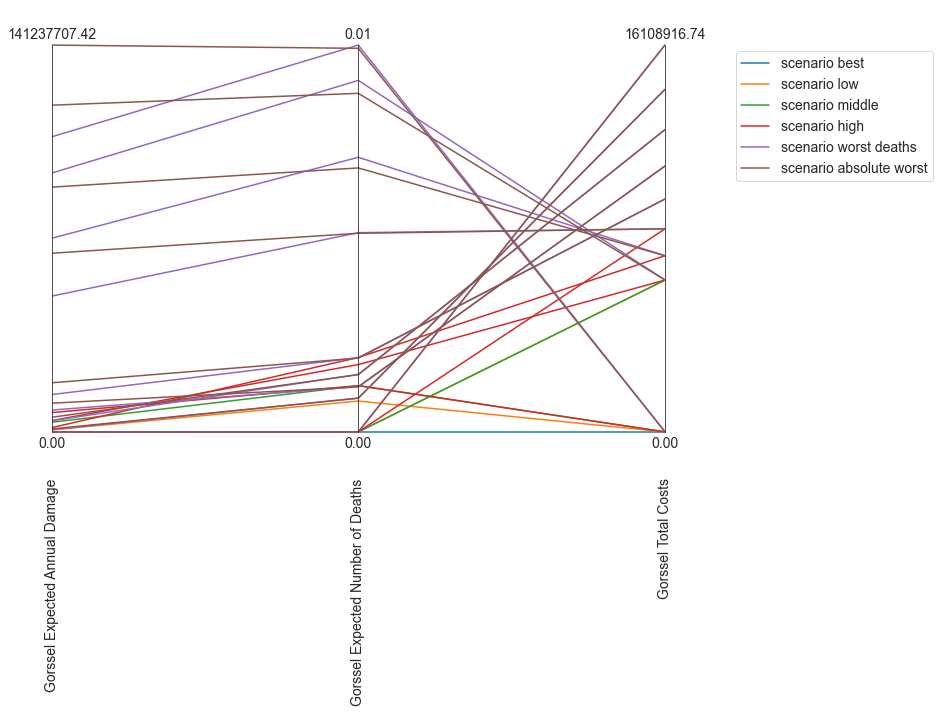

In [26]:
limits_df = belowtresh_df.iloc[:, -3:]
colors = iter(sns.color_palette())
limits = parcoords.get_limits(limits_df)

## limits.loc[0, ['inertia', 'reliability']] = 1
## limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
## limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
## limits.loc[1, :] = 0
#paraxes = parcoords.ParallelAxes(limits)
#
#for i, row in belowtresh_df.iterrows():
#    color = next(colors)
#    data = belowtresh_df.iloc[:,  -3:]
#    paraxes.plot(data, label=f'scenario {cases[i]}', color=color)
#
#paraxes.legend()
#plt.rcParams["figure.figsize"] = (10,10)
#
#plt.show()

paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(read_results):
    color = next(colors)
    data = result.iloc[:,  -3:]
    paraxes.plot(data, label=f'scenario {cases[i]}', color=color)

paraxes.legend()
plt.rcParams["figure.figsize"] = (10,10)

plt.show()